# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza2.csv"
exp_dir = "datasets/infuluenza/vecLSTM2/"

df = pd.read_csv(data_path)

In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh,Rainfall
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429,1.0
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857,41.5
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000,24.0
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000,0.0
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286,0.0


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

array([[<Axes: title={'center': 'Flucases'}>,
        <Axes: title={'center': 'Tempave'}>],
       [<Axes: title={'center': 'Rh'}>,
        <Axes: title={'center': 'Holiday'}>],
       [<Axes: title={'center': 'Rainfall'}>, <Axes: >]], dtype=object)

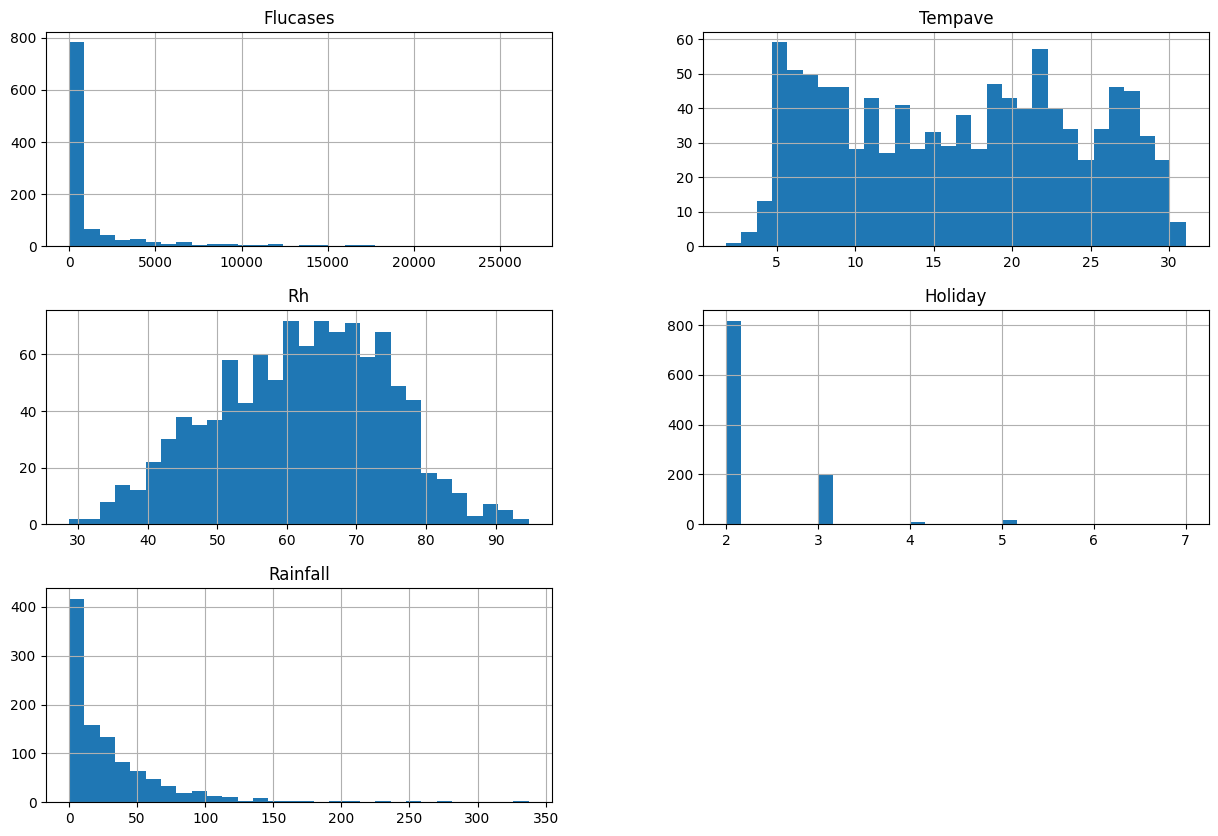

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday", "Rainfall"]

all_data = df_tokyo[columns]
all_data.hist(bins=30, figsize=(15, 10))

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday,Rainfall
12480,818,9.528571,50.571429,2,1.0
12481,1167,8.642857,61.142857,3,41.5
12482,2562,6.828571,56.000000,2,24.0
12483,3781,5.342857,42.000000,2,0.0
12484,3903,7.214286,38.714286,2,0.0


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday,Rainfall
13260,3809,5.357143,47.142857,3,6.5
13261,9892,6.285714,38.285714,2,35.5
13262,8198,5.628571,53.857143,3,19.0
13263,9625,6.771429,63.714286,2,31.5
13264,7844,4.228571,49.000000,2,9.0


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh", "Rainfall"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh", "Rainfall"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [11]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza2.csv"
data_dir = "datasets/infuluenza/vecLSTMx2/"
exp_dir = "datasets/infuluenza/vecLSTM2/"

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

In [12]:
seq_length = 52

train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [13]:
train_Xs.shape, train_ys.shape

((728, 52, 5), (728, 1, 5))

In [14]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [15]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:4])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:4])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:4])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:4])

In [16]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([582, 52, 4]),
 torch.Size([582, 1, 4]),
 torch.Size([146, 52, 4]),
 torch.Size([146, 1, 4]))

In [17]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [18]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
1 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
2 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
3 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
4 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
5 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
6 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
7 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
8 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
9 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
10 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
11 torch.Size([32, 52, 4]) torch.Size([32, 1, 4])


In [19]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
1 torch.Size([50, 52, 4]) torch.Size([50, 1, 4])
2 torch.Size([46, 52, 4]) torch.Size([46, 1, 4])


# LSTM model

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        h1 = self.relu(self.fc1(outs))
        h2 = self.fc2(h1)
        y_list = [self.relu(h2[:,0:1]), h2[:,1:3], self.relu(h2[:,3:4])]
        ys = torch.cat(y_list, dim=1)

        return ys

In [21]:
model = LSTM(input_size = 4, hidden_size = 32, output_size = 4, num_layers = 1)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Prediction

In [22]:
batch_0x = list(trn_loader)[0][0]

In [23]:
batch_0x.shape

torch.Size([50, 52, 4])

In [24]:
preds = model(batch_0x)

In [25]:
preds.shape

torch.Size([50, 4])

## Train

In [26]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(4, 32, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

In [27]:
criterion = nn.MSELoss(reduction='none').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [28]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_ys = torch.reshape(trues[:,:,0:4], (trues.shape[0], 4))
            loss = criterion(preds, true_ys).mean(dim=0).mean()
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [29]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_ys = torch.reshape(trues[:,:,0:4], (trues.shape[0], 4))
        loss = criterion(preds, true_ys).mean(dim=0).mean()
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.9436200310786566 Val loss:  0.9877562721570333
epoch:  1 Train loss:  0.894645556807518 Val loss:  0.9257765014966329
epoch:  2 Train loss:  0.8232756207386652 Val loss:  0.7958771387736002
epoch:  3 Train loss:  0.6462285071611404 Val loss:  0.5918769637743632
epoch:  4 Train loss:  0.4752030099431674 Val loss:  0.45937200387318927
epoch:  5 Train loss:  0.39009526868661243 Val loss:  0.40896062056223553
epoch:  6 Train loss:  0.3670025145014127 Val loss:  0.38204629222551983
epoch:  7 Train loss:  0.34138362978895503 Val loss:  0.3575771749019623
epoch:  8 Train loss:  0.3265782507757346 Val loss:  0.3369620591402054
epoch:  9 Train loss:  0.31277961904803914 Val loss:  0.3242698361476262
epoch:  10 Train loss:  0.30500148112575215 Val loss:  0.32004930078983307
epoch:  11 Train loss:  0.2975036030014356 Val loss:  0.31875671446323395
epoch:  12 Train loss:  0.2950924063722293 Val loss:  0.31633689006169635
epoch:  13 Train loss:  0.29564877102772397 Val loss

epoch:  114 Train loss:  0.2707129071156184 Val loss:  0.3120807558298111
epoch:  115 Train loss:  0.2680114346245925 Val loss:  0.31352590521176654
epoch:  116 Train loss:  0.2694823890924454 Val loss:  0.3115229358275731
epoch:  117 Train loss:  0.26880802338322 Val loss:  0.31184085210164386
epoch:  118 Train loss:  0.26828480263551074 Val loss:  0.3157165249188741
epoch:  119 Train loss:  0.26798132558663684 Val loss:  0.3115895489851634
epoch:  120 Train loss:  0.2734813851614793 Val loss:  0.3112400571505229
epoch:  121 Train loss:  0.26715703184405964 Val loss:  0.31008579830328625
epoch:  122 Train loss:  0.2676369473338127 Val loss:  0.30972575147946674
epoch:  123 Train loss:  0.273549385368824 Val loss:  0.30945464471975964
epoch:  124 Train loss:  0.26507634793718654 Val loss:  0.3134978413581848
epoch:  125 Train loss:  0.26825335373481113 Val loss:  0.310198316971461
epoch:  126 Train loss:  0.26570654784639675 Val loss:  0.31564535200595856
epoch:  127 Train loss:  0.267

epoch:  231 Train loss:  0.25970327978332836 Val loss:  0.31914936502774555
epoch:  232 Train loss:  0.25878449777762097 Val loss:  0.31550391515096027
epoch:  233 Train loss:  0.2566017446418603 Val loss:  0.31267981231212616
epoch:  234 Train loss:  0.25941117852926254 Val loss:  0.31282636523246765
epoch:  235 Train loss:  0.25766778364777565 Val loss:  0.3137190093596776
epoch:  236 Train loss:  0.2587149515748024 Val loss:  0.3136533598105113
epoch:  237 Train loss:  0.257945042103529 Val loss:  0.3130606214205424
epoch:  238 Train loss:  0.2576509912808736 Val loss:  0.3122626195351283
epoch:  239 Train loss:  0.2556684799492359 Val loss:  0.3123582949241002
epoch:  240 Train loss:  0.25579653307795525 Val loss:  0.30985989173253375
epoch:  241 Train loss:  0.2587771800657113 Val loss:  0.3123543510834376
epoch:  242 Train loss:  0.25660178686181706 Val loss:  0.310581107934316
epoch:  243 Train loss:  0.257168784737587 Val loss:  0.31293903291225433
epoch:  244 Train loss:  0.25

epoch:  350 Train loss:  0.2436077557504177 Val loss:  0.3144758492708206
epoch:  351 Train loss:  0.24719838301340738 Val loss:  0.3109329243501027
epoch:  352 Train loss:  0.25038063401977223 Val loss:  0.3103824456532796
epoch:  353 Train loss:  0.2517532395819823 Val loss:  0.3158952097098033
epoch:  354 Train loss:  0.24551824107766151 Val loss:  0.31072397033373517
epoch:  355 Train loss:  0.24833858758211136 Val loss:  0.312249759833018
epoch:  356 Train loss:  0.2461992440124353 Val loss:  0.3101577361424764
epoch:  357 Train loss:  0.24591784551739693 Val loss:  0.3084500233332316
epoch:  358 Train loss:  0.2447510858376821 Val loss:  0.31355053186416626
epoch:  359 Train loss:  0.2452478272219499 Val loss:  0.3132840444644292
epoch:  360 Train loss:  0.24600767716765404 Val loss:  0.31422702471415204
epoch:  361 Train loss:  0.24659868329763412 Val loss:  0.3142443100611369
epoch:  362 Train loss:  0.25479580586155254 Val loss:  0.3109603424866994
epoch:  363 Train loss:  0.2

epoch:  460 Train loss:  0.2377172696093718 Val loss:  0.31974337498346966
epoch:  461 Train loss:  0.2409250152607759 Val loss:  0.31904558340708417
epoch:  462 Train loss:  0.24092446391781172 Val loss:  0.3223303308089574
epoch:  463 Train loss:  0.23479424168666205 Val loss:  0.3181680589914322
epoch:  464 Train loss:  0.2394395793477694 Val loss:  0.3180953562259674
epoch:  465 Train loss:  0.23901299635569254 Val loss:  0.3181738207737605
epoch:  466 Train loss:  0.2368731051683426 Val loss:  0.32082446416219074
epoch:  467 Train loss:  0.23698225617408752 Val loss:  0.3203208843866984
epoch:  468 Train loss:  0.23398993412653604 Val loss:  0.3214617669582367
epoch:  469 Train loss:  0.2365746150414149 Val loss:  0.31829919914404553
epoch:  470 Train loss:  0.24278915549317995 Val loss:  0.3216476837793986
epoch:  471 Train loss:  0.23951884607474008 Val loss:  0.3200021634499232
epoch:  472 Train loss:  0.2398753141363462 Val loss:  0.31879332661628723
epoch:  473 Train loss:  0

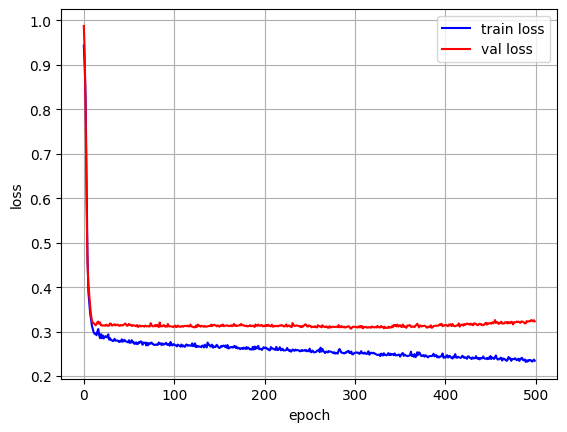

In [30]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [31]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(296, 0.306608110666275)

In [32]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [33]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [34]:
np.array(trues_list).shape, np.array(preds_list).shape

((582, 1, 4), (582, 1, 4))

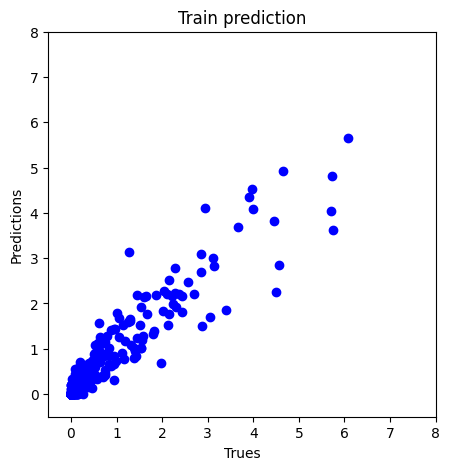

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [36]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


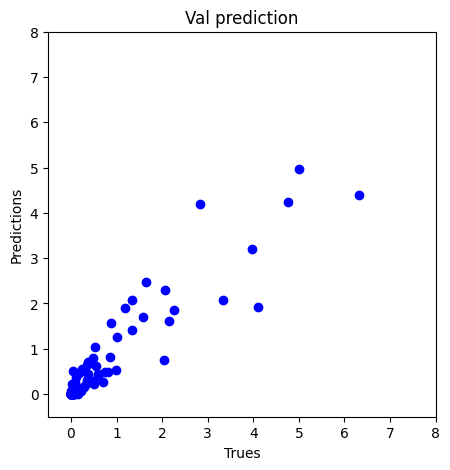

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [38]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [39]:
train_np.shape, test_np.shape

((780, 5), (260, 5))

In [40]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [41]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [42]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 500

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 10

test_scaled_zs = (np.array(test_np[:,3]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [43]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [44]:
test_scaled_ys.shape, test_scaled_zs.reshape(-1,1).shape, test_scaled_ts.reshape(-1,1).shape, test_np.shape

((260, 2), (260, 1), (260, 1), (260, 5))

In [45]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_scaled_zs.reshape(-1,1), test_np[:,-1].reshape(-1,1)], axis = 1)

In [46]:
test_all_np.shape

(260, 5)

In [47]:
test_np.shape

(260, 5)

### 1. Prediction based on results from 40 days ago

In [48]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [49]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [50]:
test_Xs.shape, test_ys.shape

((208, 52, 5), (208, 1, 5))

In [51]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:4])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:4])

In [52]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [53]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


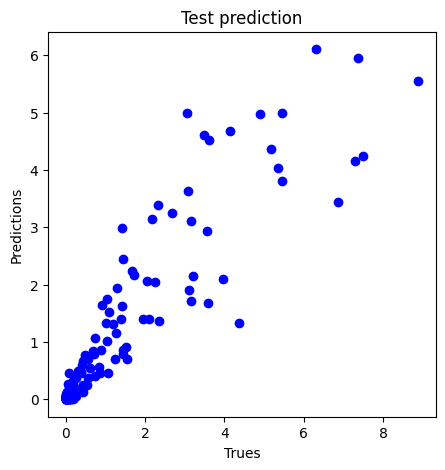

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [55]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [56]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

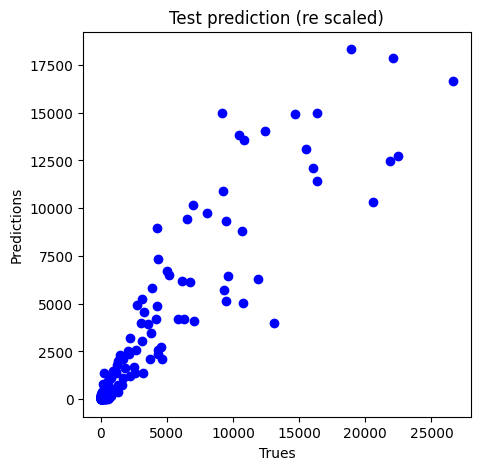

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [58]:
tst_preds.shape

(208, 1)

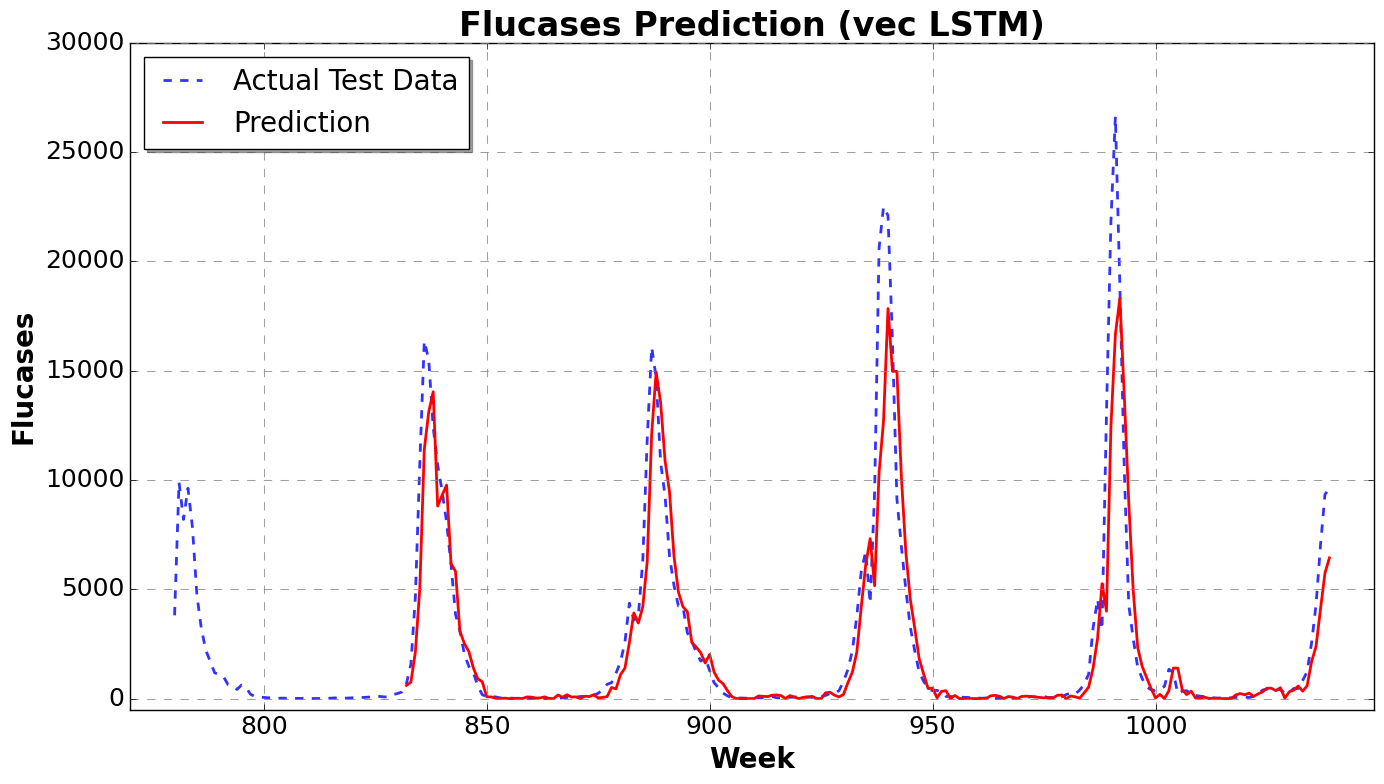

In [59]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (vec LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
#plt.savefig("Flucases Prediction (vec LSTM).jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [60]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [61]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 4009568.231609254.
RMSE : 2002.3906291254098.
MAE : 883.3761800106329.
R2 : 0.8337195362921314.
pearson : 0.9208521975044156 3.3036601268269954e-86
